# INTRO

This notebook compares the marginal average using the R-based BART Survival algorithm to our python-based BART-Survival algorithm. Reference to the R-Based algorithm will be completed with `r` denotation (ie `rbart`,`rm`) and our python-based algorithm will be referenced with `p` denotation (`pbart`, `pm`).

The rBART algorithm was completed in an external file `lung.r`. The `lung` example dataset was used from the R Survival package. Initial data preparation was completed in R and the pre-analytic set was saved as `lung.csv` to allow the exact same data input to the pBART analysis. The results from the rBART analysis are saved as `r_lung_pdp_sex.csv`. 

All comparison are made between the rBART and pBART results are made at the end of this notebook.

In [2]:
# !pip install bart-survival
# !pip install numpy
# !pip install lifelines

In [2]:
from bart_survival import surv_bart as sb
import numpy as np
import pandas as pd

# useful to remove some warnings currently generated by PYMC
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from matplotlib import pyplot as plt


# Load and Train pBART model

In [3]:
lung = pd.read_csv("lung.csv")
lung_names = lung.columns[1:]
lung = lung.to_numpy()[:,1:]
print(lung_names)
lung[:5,]

Index(['M.1..F.2.', 'age.39.82.', 'ph.karno.50.100.10.', 'times', 'delta'], dtype='object')


array([[  1,  74,  90,  11,   1],
       [  1,  68,  90,  16,   1],
       [  1,  56,  90,  34,   0],
       [  1,  57,  90,   7,   1],
       [  1,  60, 100,  30,   1]])

In [4]:
trn = sb.get_surv_pre_train(
    y_time=lung[:,3],
    y_status=lung[:,4],
    x = lung[:,:3],
    time_scale = None, # time all ready scaled to months
)

# PAD
post_test = sb.get_posterior_test(
    y_time=lung[:,3],
    y_status=lung[:,4],
    x = lung[:,2:],
    time_scale=None, # time all ready scaled to months
)

In [8]:
model_dict = {"trees": 50,
    "split_rules": [
        "pmb.ContinuousSplitRule()", # time (months)
        "pmb.OneHotSplitRule()", # sex
        "pmb.ContinuousSplitRule()",  # age
        "pmb.ContinuousSplitRule()",  # ph.karno
    ]
}
sampler_dict = {
            "draws": 200,
            "tune": 200,
            "cores": 6,
            "chains": 6,
            "compute_convergence_checks": False
        }
BSM = sb.BartSurvModel(
    model_config=model_dict, 
    sampler_config=sampler_dict
)

In [9]:
BSM.fit(
    y =  trn["y"], 
    X = trn["x"], 
    weights=trn["w"],
    coords = trn["coord"],
    random_seed=5
)


# BASELINE predictions
# Get posterior predictive for evaluation using the PAD
post1 = BSM.sample_posterior_predictive(
    X_pred=post_test["post_x"], 
    coords=post_test["coords"] 
)

# transform to survival
sv_prob = sb.get_sv_prob(post1)
print(sv_prob["prob"].shape)

Multiprocess sampling (6 chains in 6 jobs)
PGBART: [f]


/Users/jacobtiegs/projects/BART-Survival/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/Users/jacobtiegs/projects/BART-Survival/.venv/lib/python3.12/site-packages/pytensor/tensor/random/op.py:84: FutureWarning: ndim_supp is deprecated. Provide signature instead.
  warnings.warn(
/Users/jacobtiegs/projects/BART-Survival/.venv/lib/python3.12/site-packages/pytensor/tensor/random/op.py:94: FutureWarning: ndims_params is deprecated. Provide signature instead.
  warnings.warn(


Sampling 6 chains for 200 tune and 200 draw iterations (1_200 + 1_200 draws total) took 8 seconds.
Sampling: [f]


/Users/jacobtiegs/projects/BART-Survival/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

(1200, 228, 31)


# Marginal Estimation

Generate average estimates for the partial dependency for "sex = 1(male)" and "sex=2(female)".

In [10]:
# Generate PDAD over the Sex variable.
pdp1 = sb.get_pdp(lung[:, 0:3], var_col = [0], values = [[1,2]], sample_n = None)
pdp_tst = sb.get_posterior_test(
    y_time=lung[:,3], 
    y_status=lung[:,4],
    x = pdp1[0],
    time_scale=None 
)

# Yield predication for the PDAD
pdp_post = BSM.sample_posterior_predictive(pdp_tst["post_x"], pdp_tst["coords"])
# transform to survival
pdp_sv_prob = sb.get_sv_prob(pdp_post)

Sampling: [f]


/Users/jacobtiegs/projects/BART-Survival/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [11]:
# separate into the male and females 
msk = pdp1[1]["coord"]==0

pm1 = pdp_sv_prob["sv"][:,msk,:] # males
pf1 = pdp_sv_prob["sv"][:,~msk,:] # females

In [12]:
print(pm1.shape)
print(pf1.shape)
# dimensions are (draws, observations, times)

(1200, 228, 31)
(1200, 228, 31)


In [13]:
# Load the rBART results
r_sv = pd.read_csv("r_lung_pdp_sex.csv")
r_sv_cols = r_sv.columns
r_sv = r_sv.to_numpy()[:,1:]
rm1 = r_sv[r_sv[:,-1] == "male",:-1]
rf1 = r_sv[r_sv[:,-1] == "female",:-1]

Text(0.5, 0, 'Time (months)')

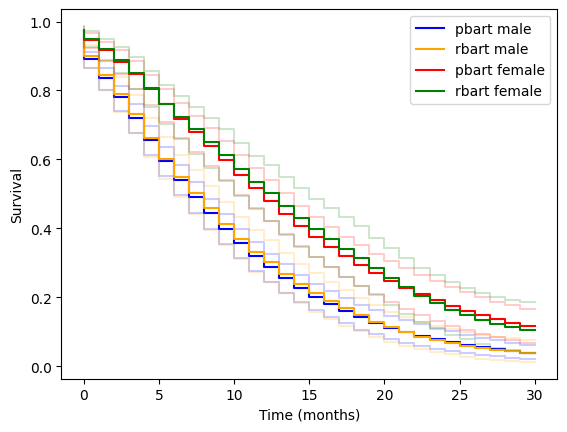

In [14]:
tttimes = pm1.shape[2]
plt.step(np.arange(tttimes),pm1.mean(1).mean(0),color ="blue", label="pbart male")
plt.step(np.arange(tttimes),np.quantile(pm1.mean(1), [0.05], axis =0)[0,:],color = "blue",alpha = .2)
plt.step(np.arange(tttimes),np.quantile(pm1.mean(1), [0.95], axis =0)[0,:],color = "blue",alpha = .2)


plt.step(np.arange(tttimes),rm1.mean(0),color ="orange", linestyle = "-", label = "rbart male")
plt.step(np.arange(tttimes),np.quantile(rm1, [0.05], axis =0)[0,:],color = "orange",alpha = .2, linestyle = "-")
plt.step(np.arange(tttimes),np.quantile(rm1, [0.95], axis =0)[0,:],color = "orange",alpha = .2, linestyle = "-")


# female
plt.step(np.arange(tttimes),pf1.mean(1).mean(0),color ="red", label="pbart female")
plt.step(np.arange(tttimes),np.quantile(pf1.mean(1), [0.05], axis =0)[0,:],color = "red",alpha = .2)
plt.step(np.arange(tttimes),np.quantile(pf1.mean(1), [0.95], axis =0)[0,:],color = "red",alpha = .2)

# female
plt.step(np.arange(tttimes),rf1.mean(0),color ="green",linestyle="-", label="rbart female")
plt.step(np.arange(tttimes),np.quantile(rf1, [0.05], axis =0)[0,:],color = "green",alpha = .2,linestyle="-")
plt.step(np.arange(tttimes),np.quantile(rf1, [0.95], axis =0)[0,:],color = "green",alpha = .2,linestyle = "-")
plt.legend()

plt.ylabel("Survival")
plt.xlabel("Time (months)")

The above plot compares the marginal effect of sex (male, female) on Survival over time from both the rBART and pBART algorithms. 

From comparing the rBART and pBART plots, there is no major differences between the point estimates of survival at the discrete times, or the credible intervals for those estimates.

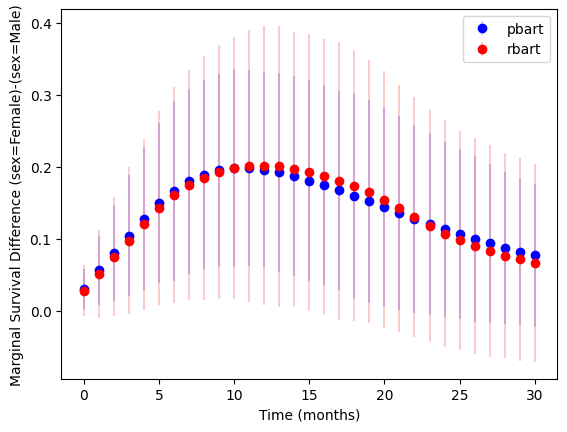

In [15]:
# Comparison of marginal difference between male and female
rdiff_m = (rf1 - rm1).mean(0)
rdiff_q = np.quantile((rf1 - rm1), [0.05,0.95], axis =0)

pdiff_m = (pf1.mean(1) - pm1.mean(1)).mean(0)
pdiff_q = np.quantile((pf1.mean(1) - pm1.mean(1)), [0.05,0.95], axis =0)

markers, caps, bars = plt.errorbar(np.arange(tttimes), pdiff_m, yerr =(pdiff_q[1,:] - pdiff_q[0,:]), fmt="o", color="blue", label = "pbart")
[cap.set_alpha(0.5) for cap in caps]
[bar.set_alpha(0.2) for bar in bars]
markers2, caps2, bars2 = plt.errorbar((np.arange(tttimes)), rdiff_m, yerr =(rdiff_q[1,:] - rdiff_q[0,:]), fmt="o", color="red", label = "rbart")
[cap.set_alpha(0.5) for cap in caps2]
[bar.set_alpha(0.2) for bar in bars2]

plt.ylabel("Marginal Survival Difference (sex=Female)-(sex=Male)")
plt.xlabel("Time (months)")
plt.legend()

Similarly, the marginal effects, taken as E(sex="female") - E(sex="Male") at each discrete time, demonstrates the two algorithms yield very similar results. 

The only considerable difference being the pBART model has slightly less conservative credible intervals, but this difference is not impactful on interpretation or confidence in the outcome.